GSEAPY Example
--------------------------------------------

### Examples to walk through ``GSEApy``

## 1.  Load essential packages

In [1]:
%matplotlib inline
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

**Check gseapy version**

In [2]:
gp.__version__

'0.9.2'

**See all gseapy supported enrichr library names** 

Enrichr library could be used for ``gsea``, ``ssgsea``, and ``prerank``, too

In [3]:
names = gp.get_library_name()
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down']

## 2. Enrichr Example

### 1)  Assign enrichr with ``pd.Series``,  ``pd.DataFrame``, or ``list`` object

In [4]:
gene_list = pd.read_table("./data/gene_list.txt",header=None)
gene_list.head()

,0
0,CTLA2B
1,SCARA3
2,LOC100044683
3,CMBL
4,CLIC6


In [5]:
type(gene_list)

pandas.core.frame.DataFrame

In [6]:
# convert dataframe or series to list
glist = gene_list.squeeze().tolist()
print(glist[:10])

['CTLA2B', 'SCARA3', 'LOC100044683', 'CMBL', 'CLIC6', 'IL13RA1', 'TACSTD2', 'DKKL1', 'CSF1', 'CITED1']


In [7]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list="./data/gene_list.txt", 
                 # or gene_list='./gene_list.txt', or gene_list=glist
                 description='test_name', 
                 gene_sets='KEGG_2016', 
                 outdir='test/enrichr_kegg', 
                 cutoff=0.5 # test dataset, use lower value of range(0,1)
                )


In [8]:
# access results throught res2d attr
enr.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,Rap1 signaling pathway_Homo sapiens_hsa04015,19/211,0.000148,0.035223,0.000436,0.103734,-1.961363,17.295956,PDGFRB;CSF1;FLT4;VEGFC;ARAP3;LPAR4;ADCY7;ADCY6...
1,Pathways in cancer_Homo sapiens_hsa05200,27/397,0.000729,0.066282,0.001816,0.152127,-2.083086,15.046848,RET;LEF1;TGFA;LPAR4;ADCY7;ETS1;ADCY6;GLI2;FGF4...
2,Ras signaling pathway_Homo sapiens_hsa04014,18/227,0.000999,0.066282,0.002351,0.152127,-1.956845,13.519663,PDGFRB;CSF1;FLT4;VEGFC;ETS1;GNG13;FGF4;PLD2;EF...
3,Dilated cardiomyopathy_Homo sapiens_hsa05414,10/90,0.001114,0.066282,0.002557,0.152127,-1.805957,12.280169,DES;SGCB;TPM2;TNNC1;LMNA;TPM1;ITGAV;ADCY7;ADCY...
4,HTLV-I infection_Homo sapiens_hsa05166,19/258,0.001747,0.083151,0.003877,0.184562,-1.843079,11.703417,PDGFRB;STAT5B;EGR1;JUN;CD40;FZD2;CRTC3;NFATC1;...


### 2) Command line usage 

You may also want to use enrichr in command line  

the option **-v** will print out the progress of your job

In [9]:
!gseapy enrichr -i ./data/gene_list.txt \
               --description BP2017 \
               -g GO_Biological_Process_2017 \
               -v -o test/enrichr_BP

/bin/sh: gseapy: command not found


## 3. Prerank example

### 1) Assign prerank()  with a pd.DataFrame, pd.Series , or a txt file
Do not include header !  
GSEApy will skip any comment lines startswith "#".  
Only contains two columns, or one cloumn with gene_name indexed when assign a ``DataFrame`` to prerank

In [10]:
rank = pd.read_table("./data/edb/gsea_data.gsea_data.rnk", header=None)
rank.head()

,0,1
0,CTLA2B,2.502482
1,SCARA3,2.095578
2,LOC100044683,1.116398
3,CMBL,0.877640
4,CLIC6,0.822181


In [11]:
# run prerank
# enrichr libraries are supported by prerank module. Just provide the name
pre=[]
for s, n in zip(['./data/genes.gmt', 'KEGG_2016'],['bp','kegg']):
    #use 4 process to acceralate the permutation speed
    pre_res = gp.prerank(rnk=rank, 
                         gene_sets=s, 
                         processes=4,
                         permutation_num=100, # reduce number to speed up test
                         outdir='test/prerank_report_'+n,format='png')
    pre.append(pre_res)

In [12]:
#access results through res2d attribute
pre[0].res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes
Term,,,,,,,
DvA_UpIN_A,0.405880,1.520157,0.083333,0.155039,284,19,"ABHD14B,VNN1,NELF,MARVELD2,LAMB3,TMPRSS2,TM6SF..."
DvA_UpIN_D,0.166924,0.605093,0.826087,0.860465,236,21,"PMP22,STBD1,DUSP14,RET,GPX8,CHRNB1,PRKD1,COL7A..."


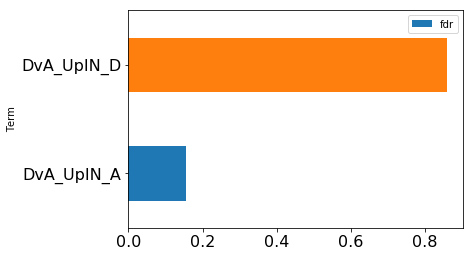

In [13]:
# plotting
pre_res = pre[0]
prerank_results = pre_res.res2d
prerank_results = prerank_results.reset_index()
prerank_results.head(5).plot.barh(y='fdr',x='Term',fontsize=16)

### 2) Command line usage 

You may also want to use prerank in command line

In [14]:
# ! gseapy prerank -r temp.rnk -g temp.gmt -o prerank_report_temp

## 4. GSEA Example

### 1)  Assign gsea() with a pandas DataFrame, .gct format file, or a text file

and cls with a list object or just .cls format file 

In [15]:
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./data/P53.cls")

In [16]:
#class_vector used to indicate group attributes for each sample
print(class_vector)

['MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT']


In [17]:
gene_exp = pd.read_table("./data/P53_resampling_data.txt")
gene_exp.head()

,NAME,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,CTLA2B,111.19,86.22,121.85,75.19,208.62,130.59,124.72,324.09,242.71,...,163.76,59.50,134.12,152.09,197.46,137.79,81.53,123.37,81.41,180.78
1,SCARA3,460.30,558.34,183.55,37.29,158.00,43.61,80.83,300.08,1250.25,...,109.91,120.42,73.06,115.03,95.12,37.56,76.16,41.10,77.51,519.17
2,LOC100044683,97.25,118.94,81.17,119.51,119.88,107.73,165.57,203.97,135.43,...,222.84,124.98,114.75,141.66,170.19,147.70,157.48,152.18,98.89,118.06
3,CMBL,33.45,55.10,221.67,50.30,35.12,75.70,84.01,44.12,79.96,...,51.32,117.11,59.46,78.46,45.55,49.07,96.69,33.09,10.38,52.89
4,CLIC6,35.75,41.26,63.04,219.86,42.53,54.19,86.98,71.20,53.89,...,154.05,31.62,37.66,32.64,63.35,27.95,70.99,36.25,17.50,49.41


In [18]:
print("positively correlated: ", phenoA)

positively correlated:  MUT


In [19]:
print("negtively correlated: ", phenoB)

negtively correlated:  WT


In [20]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name

gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='KEGG_2016', # enrichr library names
                 cls=class_vector, # or cls= './P53.cls'
                 #set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype', 
                 permutation_num=100, # reduce number to speed up test
                 outdir='test/gsea_report', 
                 method='signal_to_noise', 
                 format='png')

2017-12-29 18:48:24,530 Warning: dropping duplicated gene names, only keep the first values


In [21]:
#access the dataframe results throught res2d attribute
gs_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes
Term,,,,,,,
Rap1 signaling pathway_Homo sapiens_hsa04015,-0.286127,-0.975607,0.490196,0.789889,211,19,"RRAS,VEGFC,CSF1,FGF17,PDGFRB,FGF4,PDGFC,SIPA1L..."
Focal adhesion_Homo sapiens_hsa04510,-0.275712,-0.758252,0.792453,0.824645,202,15,"ILK,VEGFC,SOS2,ERBB2,THBS4,PDGFRB,PDGFC,ITGAV,..."
HTLV-I infection_Homo sapiens_hsa05166,-0.250191,-0.846597,0.695652,0.859005,258,19,"FZD2,ETS1,STAT5B,RRAS,LTBR,PPP3CC,TNFRSF1A,EGR..."
PI3K-Akt signaling pathway_Homo sapiens_hsa04151,0.181505,0.566069,0.960000,0.966527,341,22,"CLIC6,VEGFC,GNB4,CSF1,SOS2,FGF17,THBS4,PDGFRB,..."
Cytokine-cytokine receptor interaction_Homo sapiens_hsa04060,0.228141,0.663464,0.880000,1.000000,265,18,"IL10RB,VEGFC,CSF1,TNFSF12,LTBR,CXCL10,TNFRSF1A..."


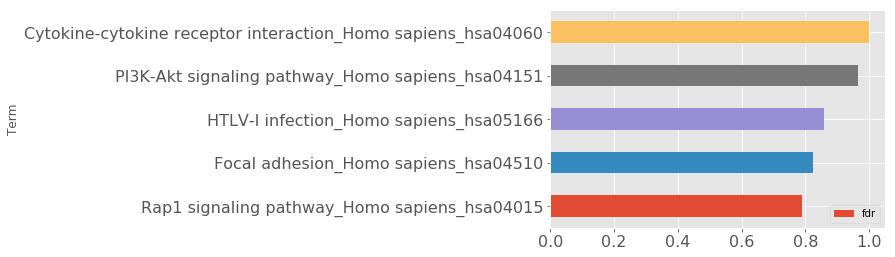

In [22]:
# plotting
gsea_results= gs_res.res2d
with plt.style.context('ggplot'):
    gsea_results = gsea_results.reset_index()
    gsea_results.head(5).plot.barh(y='fdr',x='Term',fontsize=16)

### 2) Show the gsea plots

The **gsea** module will generate heatmap for genes in each gene sets in the backgroud.

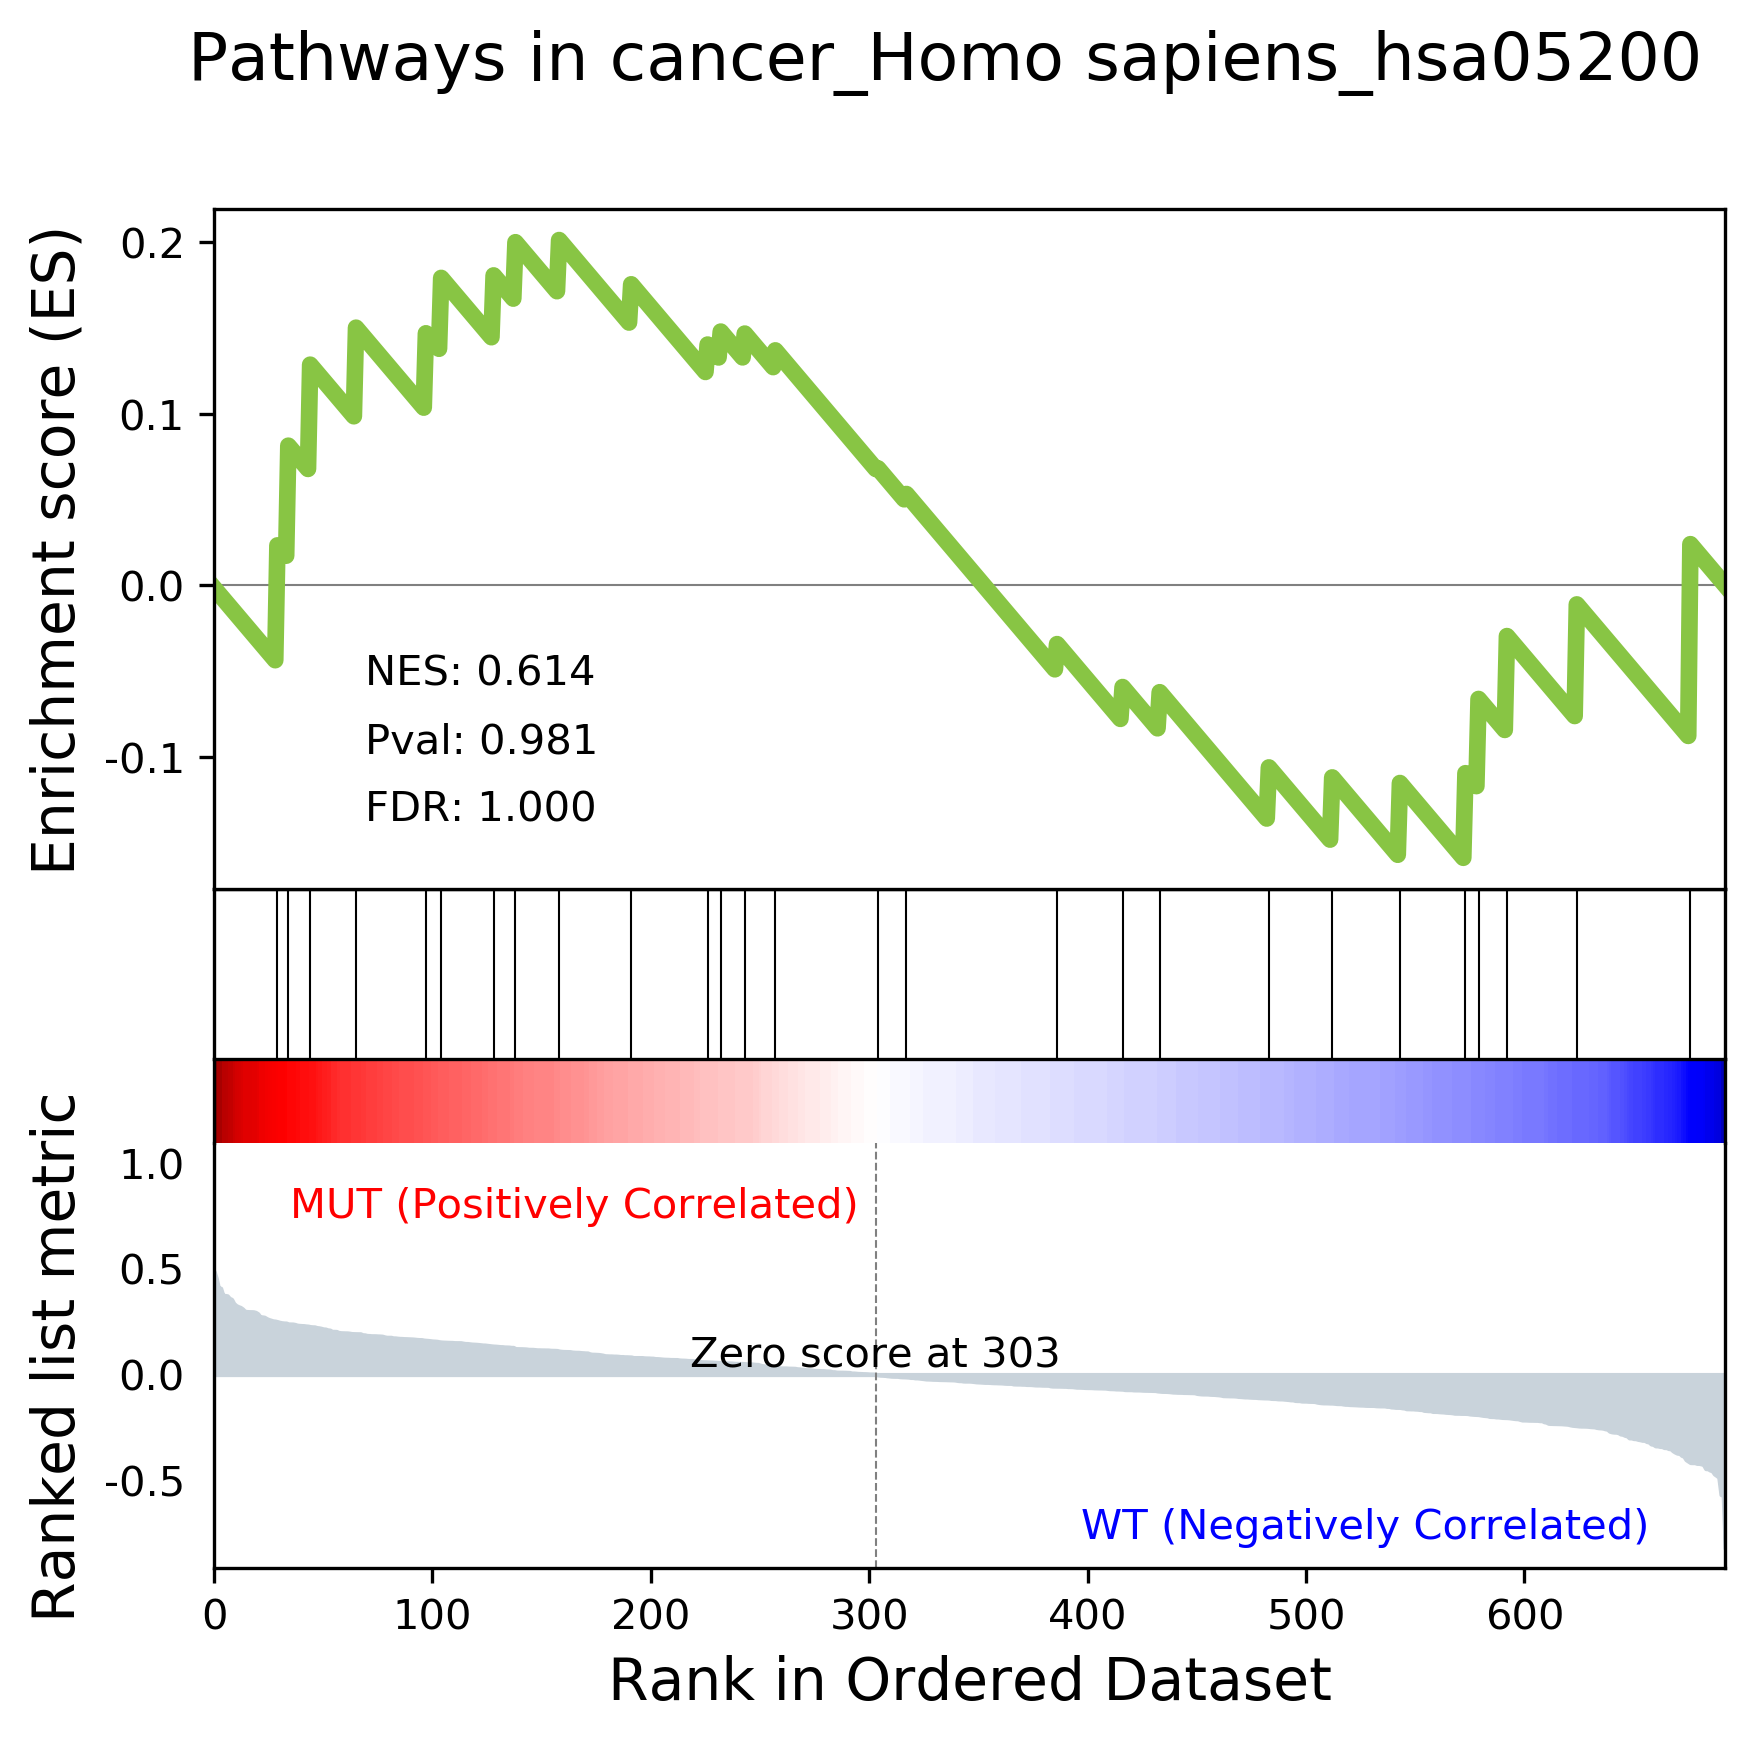

In [23]:
from IPython.display import Image

#erich plot
Image("./test/gsea_report/Pathways in cancer_Homo sapiens_hsa05200.gsea.png",width=650, height=600)

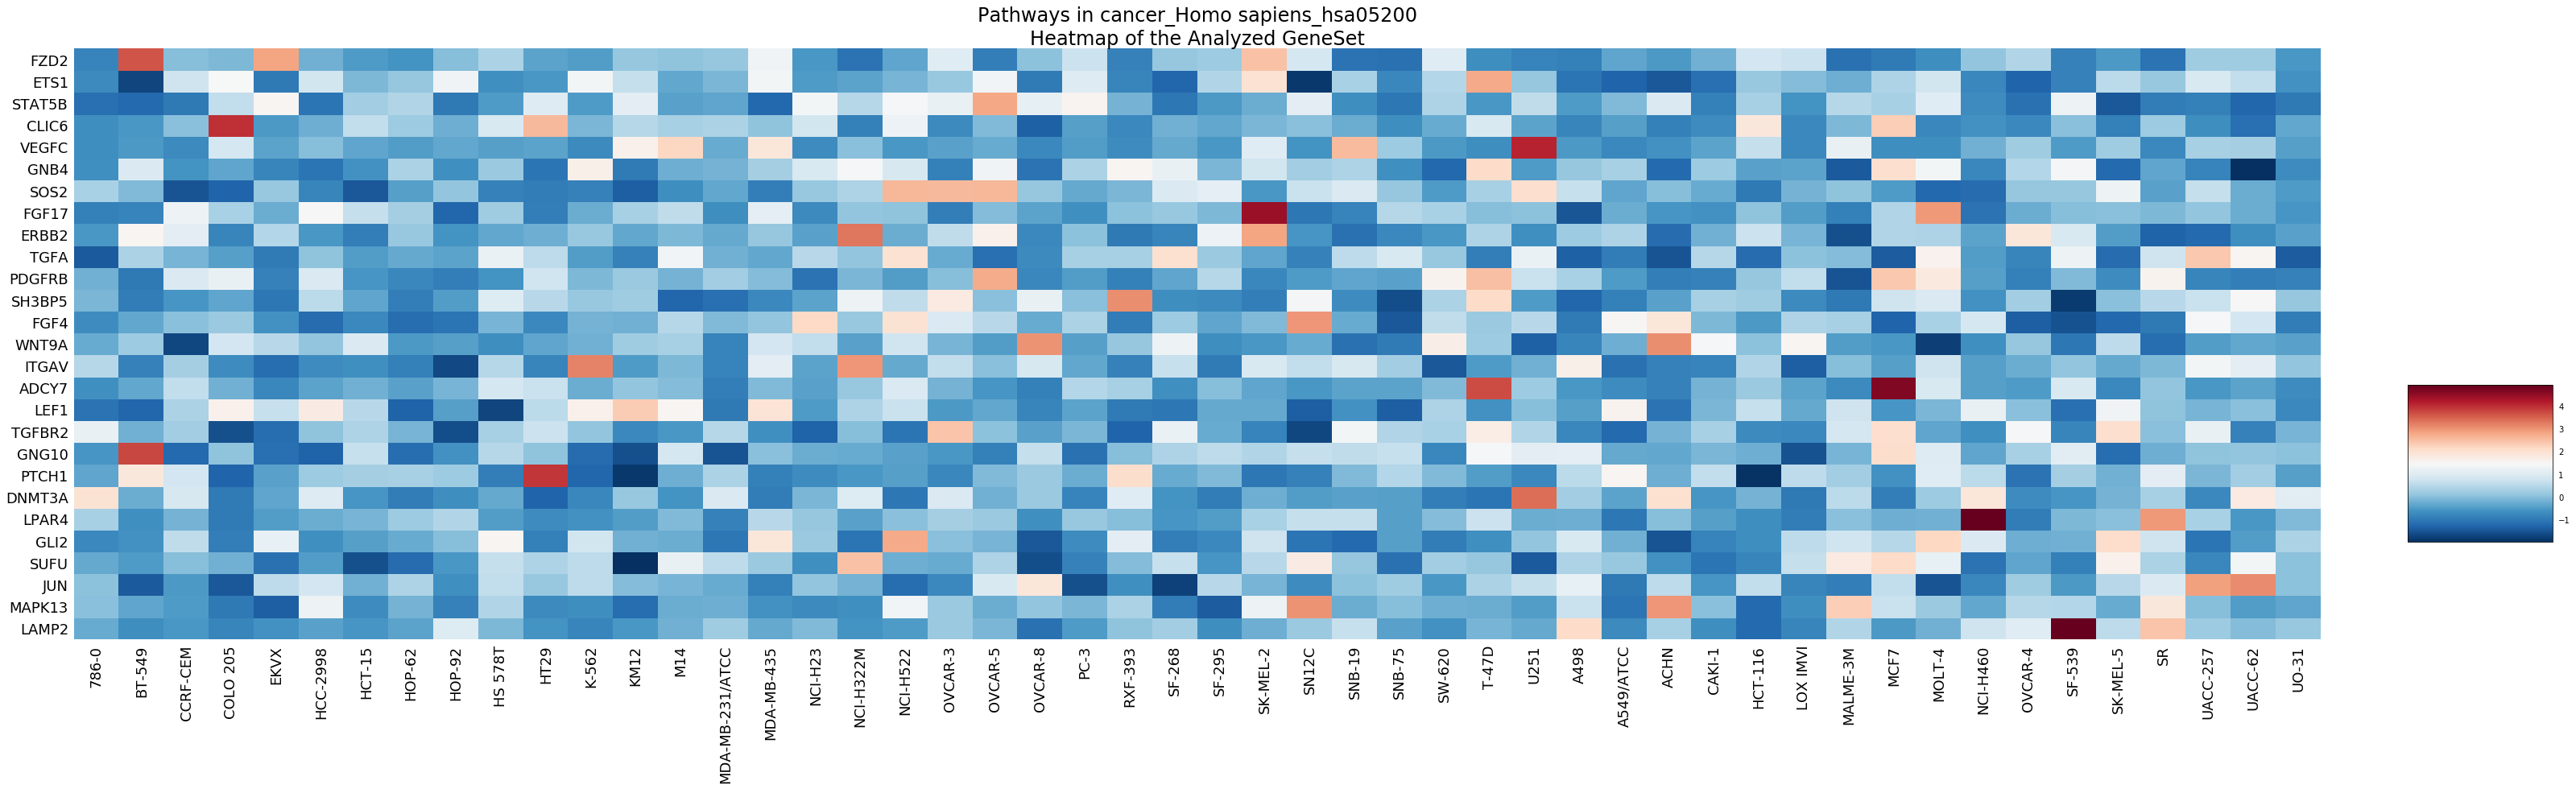

In [24]:
#corresponding heatmap
Image("./test/gsea_report/Pathways in cancer_Homo sapiens_hsa05200.heatmap.png")

### 3) Command line usage 

You may also want to use gsea in command line

In [25]:
# !gseapy gsea -d ./data/P53_resampling_data.txt \
#              -g KEGG_2016 -c ./data/P53.cls \
#              -o test/gsea_reprot_2 \
#              -v --no-plot \
#              -t phenotype

## 5. Single Sample GSEA example

**Note: When you run ssGSEA, all genes names in your gene_sets file should be found in your expression table**

### 1) Assign ssgsea() with a txt file, gct file, pd.DataFrame, or pd.Seires(gene name as index).  


In [26]:
# txt, gct file input
ss = gp.ssgsea(data="./data/testSet_rand1200.gct",
               gene_sets="./data/randomSets.gmt", 
               outdir='test/ssgsea_report', 
               sample_norm_method='rank', # choose 'custom' for your own rank list
               permutation_num=0, # skip permutation procedure, because you do need it
               processes=4, format='png')

In [27]:
# or assign a dataframe, or Series to ssgsea()
ssdf = pd.read_table("./data/temp.txt",header=None)
ssdf.head()

,0,1
0,ATXN1,16.456753
1,UBQLN4,13.989493
2,CALM1,13.745533
3,DLG4,12.796588
4,MRE11A,12.787631


In [28]:
# dataframe with one column is also supported by ssGSEA or Prerank
# But you have to set gene_names as index
ssdf2 = ssdf.set_index(0)
ssdf2.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [29]:
type(ssdf2)

pandas.core.frame.DataFrame

In [30]:
ssSeries = ssdf2.squeeze()
type(ssSeries)

pandas.core.series.Series

In [31]:
# reuse data
df = pd.read_table("./data/P53_resampling_data.txt")
df.head()

,NAME,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,CTLA2B,111.19,86.22,121.85,75.19,208.62,130.59,124.72,324.09,242.71,...,163.76,59.50,134.12,152.09,197.46,137.79,81.53,123.37,81.41,180.78
1,SCARA3,460.30,558.34,183.55,37.29,158.00,43.61,80.83,300.08,1250.25,...,109.91,120.42,73.06,115.03,95.12,37.56,76.16,41.10,77.51,519.17
2,LOC100044683,97.25,118.94,81.17,119.51,119.88,107.73,165.57,203.97,135.43,...,222.84,124.98,114.75,141.66,170.19,147.70,157.48,152.18,98.89,118.06
3,CMBL,33.45,55.10,221.67,50.30,35.12,75.70,84.01,44.12,79.96,...,51.32,117.11,59.46,78.46,45.55,49.07,96.69,33.09,10.38,52.89
4,CLIC6,35.75,41.26,63.04,219.86,42.53,54.19,86.98,71.20,53.89,...,154.05,31.62,37.66,32.64,63.35,27.95,70.99,36.25,17.50,49.41


In [32]:
# Series, DataFrame Example
# supports dataframe and series
ssgs = []
for i, dat in enumerate([ssdf, ssdf2, ssSeries, df]):
    sstemp = gp.ssgsea(data=dat, 
                       gene_sets="./data/genes.gmt", 
                       outdir='test/ssgsea_report_'+str(i),
                       permutation_num=0, # skip permutation procedure, because you do need it
                       no_plot=True, # skip plotting to speed up
                       processes=4, format='png')
    ssgs.append(sstemp)

2017-12-29 18:50:47,128 Warning: dropping duplicated gene names, only keep the first values


### 2) Access Enrichment Score (ES) and NES

results save to two attribute:

1. obj.resultsOnSamples: ES
2. obj.res2d: NES

In [33]:
# normalized es save to res2d attri
# one sample input
# NES
ssgs[0].res2d.head()

,1
Term|NES,
BvA_UpIN_A,2.150114
BvA_UpIN_B,2.953848
DvA_UpIN_A,1.985451
DvA_UpIN_D,2.457489
YvX_UpIN_X,2.148816


In [34]:
# ES
# convert dict to DataFrame
es = pd.DataFrame(ssgs[-1].resultsOnSamples)
es.head()

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|ES,,,,,,,,,,,,,,,,,,,,,
BvA_UpIN_B,0.028486,0.097813,0.182507,0.077038,0.073571,0.030582,0.114052,0.073989,0.055725,0.092490,...,0.071700,0.144316,0.085519,0.084900,0.088850,0.054312,0.088459,0.034827,0.057861,0.066410
DvA_UpIN_A,0.053314,0.023136,0.014449,0.023323,0.047344,0.012175,-0.000789,0.031296,0.031028,0.058557,...,0.012899,0.015929,0.061726,0.071686,0.032855,0.043741,0.016428,0.077493,0.086825,0.064301
DvA_UpIN_D,0.102190,0.121601,0.112050,0.080343,0.104164,0.087211,0.061129,0.085213,0.104486,0.117154,...,0.098602,0.103358,0.128819,0.137535,0.109884,0.097751,0.085923,0.112544,0.106176,0.110375


In [35]:
# NES 
nes = ssgs[-1].res2d
nes.head()

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|NES,,,,,,,,,,,,,,,,,,,,,
BvA_UpIN_B,0.132580,0.455243,0.849433,0.358551,0.342419,0.142337,0.530826,0.344362,0.259360,0.430473,...,0.333710,0.671683,0.398024,0.395145,0.413528,0.252780,0.411709,0.162091,0.269300,0.309089
DvA_UpIN_A,0.248137,0.107681,0.067247,0.108549,0.220351,0.056663,-0.003672,0.145661,0.144410,0.272539,...,0.060036,0.074139,0.287290,0.333644,0.152915,0.203582,0.076462,0.360670,0.404104,0.299274
DvA_UpIN_D,0.475616,0.565961,0.521509,0.373935,0.484804,0.405900,0.284510,0.396600,0.486301,0.545264,...,0.458916,0.481053,0.599555,0.640120,0.511426,0.454959,0.399905,0.523808,0.494169,0.513710


### 3) command line usage of single sample gsea

In [36]:
!gseapy ssgsea -d ./data/testSet_rand1200.gct \
               -g data/temp.gmt \
               -o test/ssgsea_report2  \
               -p 4 --no-plot

## 6. Replot Example

### 1) locate your directory

notes: ``replot`` module need to find edb folder to work properly.
keep the file tree like this:
```
data
 |--- edb
 |    |--- C1OE.cls
 |    |--- gene_sets.gmt
 |    |--- gsea_data.gsea_data.rnk
 |    |--- results.edb

```

In [37]:
# run command inside python console
rep = gp.replot(indir="./data", outdir="test/replot_test")

### 2) command line usage of replot

In [38]:
# !gseapy replot -i data -o test/replot_test